c:\Users\riko.lusa\src\phd-i4sec\.venv\Lib\site-packages\dgl\dataloading\dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


{
  "accuracy": 0.9499427869249805,
  "macro": {
    "precision": 0.4882452172991768,
    "recall": 0.6087298587178906,
    "f1": 0.4503453386641302
  },
  "macro_FAR": 0.005075783380869556
}
False negatives by class: {'Analysis': 173, 'Backdoor': 144, 'Benign': 2403, 'DoS': 2286, 'Exploits': 15538, 'Fuzzers': 7879, 'Generic': 2685, 'Reconnaissance': 4059, 'Shellcode': 337, 'Worms': 18}


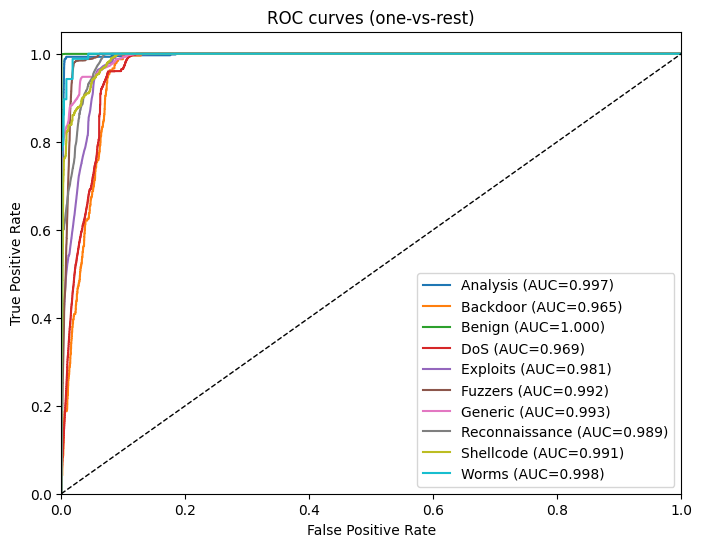

In [4]:
import os, json, joblib, dgl, torch
import numpy as np
from feature_store import fetch_edge_features
from eval_utils import make_eval_loader
from eval_infer import infer_split
from eval_metrics import compute_metrics
from eval_roc import plot_roc_ovr, false_negatives_by_class

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load artifacts
g_val = dgl.load_graphs("graphs/val.bin")[0][0]
fs_val = "feature_store/val"

# label map
with open("artifacts/label_map.json","r",encoding="utf-8") as f:
    label2id = json.load(f)
id2label = {v:k for k,v in label2id.items()}
classes  = [id2label[i] for i in range(len(label2id))]

# Rebuild the model (must match your training config)
edge_in = fetch_edge_features(np.load(os.path.join(fs_val,"edge_indices.npy"))[:1], fs_val).shape[1]
hidden  = 128  # set to what you trained with
num_classes = len(label2id)

from train_edgecls_dbg import _FallbackEdgeGraphSAGE  # your class
model = _FallbackEdgeGraphSAGE(in_node=0, edge_in=edge_in, hidden=hidden, num_classes=num_classes, dropout=0.3).to(device)
model.load_state_dict(torch.load("artifacts/best_edge_sage.pt", map_location=device))
model.eval()

# Build loader for VAL
val_loader = make_eval_loader(g_val, fs_val, fanouts=(25,15), batch_size=2048)

# Inference
y_true, y_pred, y_prob = infer_split(model, val_loader, g_val, device, fetch_edge_features)

# Metrics
metrics = compute_metrics(y_true, y_pred, label2id)
print(json.dumps({
    "accuracy": metrics["accuracy"],
    "macro": metrics["macro"],
    "macro_FAR": metrics["macro_FAR"]
}, indent=2))
# Confusion Matrix & FN
cm = np.array(metrics["confusion_matrix"])
fn_by_class = false_negatives_by_class(cm, classes)
print("False negatives by class:", fn_by_class)

# Save metrics
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/metrics_val.json","w") as f:
    json.dump(metrics, f, indent=2)

# ROC curves
plot_roc_ovr(y_true, y_prob, classes, out_path="artifacts/roc_val.png")


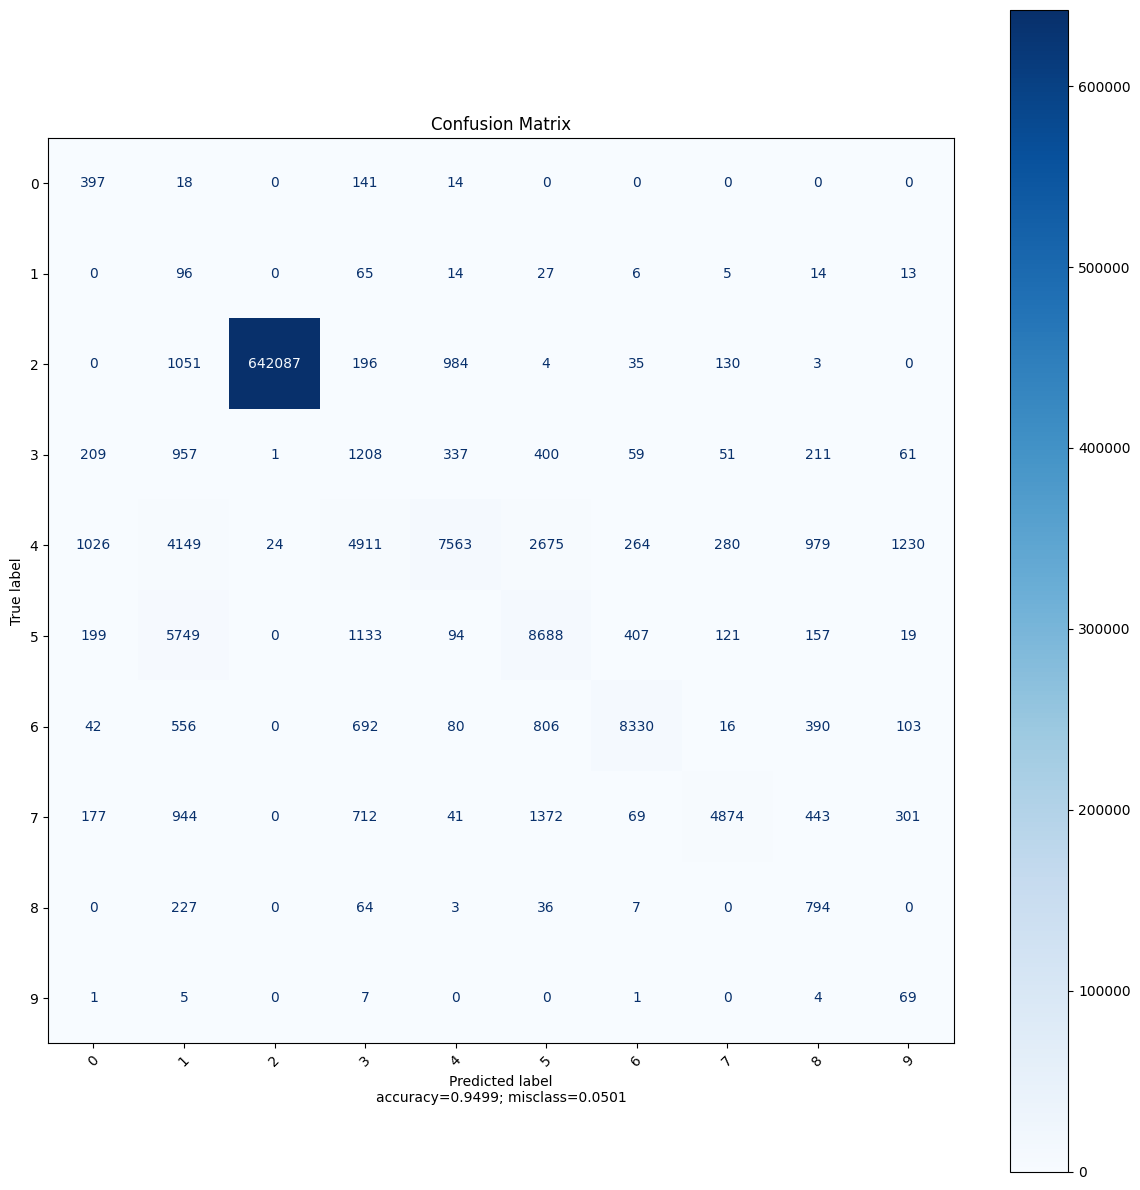

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# use inference outputs (y_true, y_pred) produced earlier in the notebook
cm = confusion_matrix(y_true, y_pred)
labels = np.unique(y_true)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap=plt.get_cmap('Blues'), colorbar=True)
plt.title("Confusion Matrix")
plt.xlabel(f'Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\riko.lusa\AppData\Local\Temp\ipykernel_7472\4264038451.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


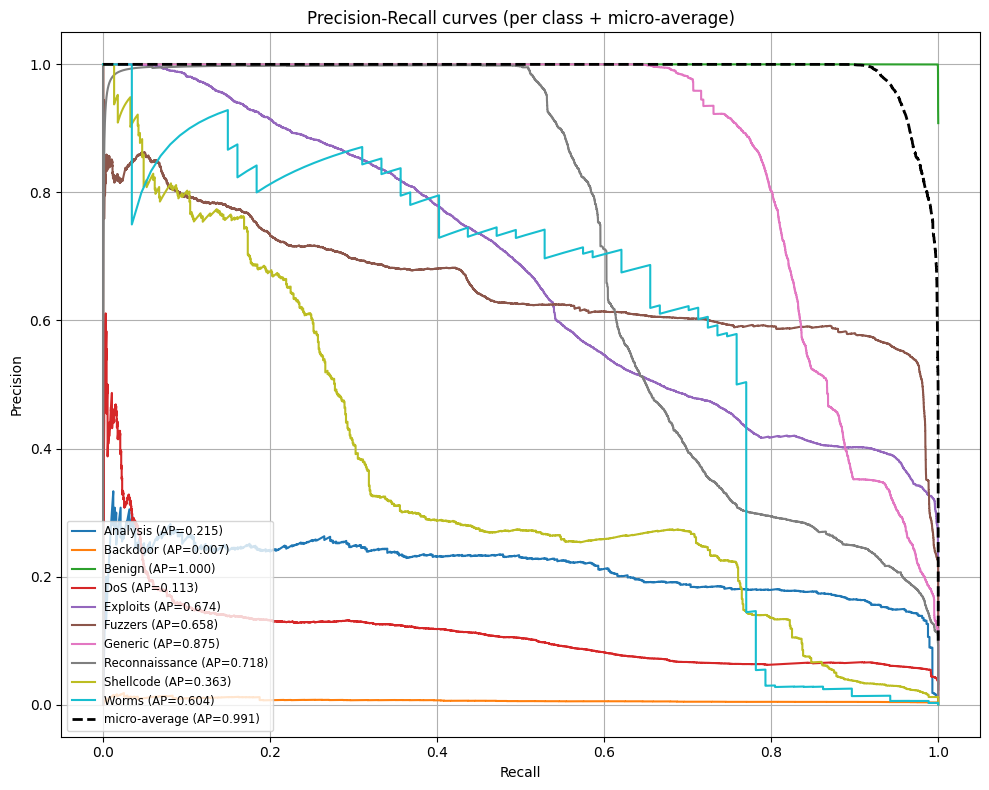

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

# Ensure y_prob is a NumPy array (infer_split returned logits)
if isinstance(y_prob, torch.Tensor):
    y_prob = y_prob.detach().cpu().numpy()

# Convert logits -> probabilities
if y_prob.ndim == 1 or (y_prob.ndim == 2 and y_prob.shape[1] == 1):
    # Binary single-logit output -> sigmoid
    logits = y_prob.reshape(-1)
    probs_pos = 1.0 / (1.0 + np.exp(-logits))
    y_prob = np.vstack([1.0 - probs_pos, probs_pos]).T
else:
    # Multi-class logits (including 2-column logits) -> softmax
    logits = y_prob
    logits = logits - np.max(logits, axis=1, keepdims=True)
    exp = np.exp(logits)
    y_prob = exp / exp.sum(axis=1, keepdims=True)

# y_true (N,), y_prob (N, C) ready for PR plotting
num_classes = y_prob.shape[1]

# binarize true labels
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# compute per-class PR and AP
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10')
for i in range(num_classes):
    prec, rec, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(rec, prec, label=f"{classes[i]} (AP={ap:0.3f})", color=colors(i % 10))

# micro-average
prec_micro, rec_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_prob.ravel())
ap_micro = average_precision_score(y_true_bin, y_prob, average="micro")
plt.plot(rec_micro, prec_micro, label=f"micro-average (AP={ap_micro:0.3f})", color='black', linewidth=2, linestyle='--')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curves (per class + micro-average)")
plt.legend(loc="lower left", fontsize="small")
plt.grid(True)
plt.tight_layout()

os.makedirs("artifacts", exist_ok=True)
plt.savefig("artifacts/pr_curve_val.png", dpi=200)
plt.show()